# Efficiency Notebooks: Exploring the emissions density of power used by homes
We'll be using data from the Texas ISO, ERCOT, to calculate the emissions amount and emission sources from the generated power used by the electrical grid home usage.

Entirely solar equipped homes will be used to demonstrate the interplay between solar generation and emissions during this time period (March - August 2018)

ERCOT emissions/generation data pulled from http://www.ercot.com/content/wcm/lists/181766/FuelMixReport_PreviousYears.zip 
which you can find at http://www.ercot.com/gridinfo/generation

In [1]:
#import packages
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import sqlalchemy as sqla
import os
import sys
sys.path.insert(0,'..')
from config.read_config import get_database_config
import numpy as np
import statistics
%matplotlib inline
sys.executable  # shows you your path to the python you're using

'/opt/conda/bin/python'

In [2]:
# set constants for lbs of CO2 / kWh
_gas_cc_lbs = 0.75
_gas_lbs = 1.0
_coal_lbs = 2.21

In [3]:
# read in db credentials from ../config/config.txt
# * make sure you add those to the ../config/config.txt file! *

## Uncomment the following line to use the live database queries

database_config = get_database_config("../config/config.txt")

#

In [4]:
# get our DB connection

# uncomment if you want to use the live queries to the database instead of the prepared data

engine = sqla.create_engine('postgresql://{}:{}@{}:{}/{}'.format(database_config['username'],
                                                                     database_config['password'],
                                                                     database_config['hostname'],
                                                                     database_config['port'],
                                                                     database_config['database']
                                                                     ))


In [5]:
#Select a list of Austin homes from dataport metadata with good data availability for grid
query = """select distinct dataid, egauge_1min_data_availability, grid, solar from other_datasets.metadata 
                                          where grid = 'yes'
                                          and solar = 'yes'
                                          and egauge_1min_min_time <= '2018-03-01' 
                                          and egauge_1min_max_time > '2018-09-01'
                                          and city='Austin'
                                          and (egauge_1min_data_availability like '100%' 
                                               or 
                                               egauge_1min_data_availability like '99%'
                                               or
                                               egauge_1min_data_availability like '98%'
                                               or
                                               egauge_1min_data_availability like '97%'
                                               )
                                          and gas_ert_min_time <= '2018-03-01'
                                          and gas_ert_max_time > '2018-09-01'
                                          limit 50
                                          ;
         """

df = pd.read_sql_query(sqla.text(query), engine)
df

,dataid,egauge_1min_data_availability,grid,solar
0,187,97%,yes,yes
1,252,100%,yes,yes
2,661,97%,yes,yes
3,744,99%,yes,yes
4,1792,100%,yes,yes
5,2072,100%,yes,yes
6,2233,97%,yes,yes
7,2335,97%,yes,yes
8,2461,97%,yes,yes
9,2470,98%,yes,yes


In [6]:
# grab dataids and convert them to a string to put into the SQL query
dataids_list = df['dataid'].tolist()
print("{} dataids selected listed here:".format(len(dataids_list)))
dataids_str = ','.join(list(map(str, dataids_list)))
dataids_str

45 dataids selected listed here:


'187,252,661,744,1792,2072,2233,2335,2461,2470,2814,2925,2980,3039,3527,3849,3967,4447,4767,5129,5395,5403,5439,5545,5658,6412,6578,7017,7024,7030,7429,7504,7739,7741,7965,7989,8084,8086,8626,9052,9121,9134,9160,9971,9982'

In [7]:
#Pull electricity data for selected homes.
data = """select dataid,localminute::timestamp,grid 
               from electricity.eg_realpower_1min 
               where localminute >= '2018-03-01' and localminute <  '2018-09-01' """
data = data + """AND dataid in ({})""".format(dataids_str)

# create a dataframe with the data from the sql query
grid_df = pd.read_sql_query(sqla.text(data), engine)

grid_df

,dataid,localminute,grid
0,9121,2018-03-01 00:27:00,0.294
1,8626,2018-03-01 04:27:00,0.520
2,8626,2018-03-01 04:46:00,0.457
3,8626,2018-03-01 04:59:00,0.454
4,8626,2018-03-01 05:05:00,0.461
...,...,...,...
11680747,2814,2018-03-01 00:02:00,0.459
11680748,2814,2018-03-01 00:03:00,0.459
11680749,2814,2018-03-01 00:04:00,0.459
11680750,2814,2018-03-01 00:05:00,0.458


In [8]:
# read in 2018 ERCOT emissions data
ercot = pd.read_csv('ercot_emissions_2018.csv')

# index by Energy, GWh  
ercot = ercot.set_index('Energy, GWh')

# remove the commas from the numbers
ercot.replace(',','', regex=True, inplace=True)

# convert to a float from a string
ercot = ercot.astype('float64')

ercot

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
"Energy, GWh",,,,,,,,,,,,,
Biomass,56.0,43.0,38.0,33.0,66.0,63.0,67.0,58.0,31.0,32.0,32.0,42.0,563.0
Coal,8891.0,5899.0,4990.0,6132.0,7524.0,8758.0,9339.0,9491.0,8765.0,8199.0,7704.0,7558.0,93249.0
Gas,1411.0,661.0,884.0,951.0,2779.0,2558.0,4183.0,3661.0,2096.0,2014.0,1326.0,962.0,23487.0
Gas-CC,10690.0,10134.0,9923.0,8801.0,12136.0,14854.0,17438.0,16202.0,13775.0,10404.0,8767.0,10594.0,143719.0
Hydro,32.0,32.0,53.0,61.0,60.0,49.0,44.0,55.0,38.0,139.0,132.0,113.0,811.0
Nuclear,3809.0,3433.0,3528.0,2783.0,3746.0,3593.0,3706.0,3622.0,3589.0,2909.0,3297.0,3111.0,41125.0
Other,3.0,1.0,2.0,2.0,3.0,2.0,4.0,1.0,2.0,3.0,3.0,2.0,29.0
Solar,190.0,165.0,241.0,297.0,340.0,368.0,367.0,354.0,257.0,209.0,250.0,203.0,3240.0
Wind,6237.0,5534.0,6625.0,6717.0,7060.0,7059.0,4293.0,5569.0,3778.0,5227.0,5592.0,6105.0,69796.0


In [9]:
# Calc just one of them months and sources for a sanity check
perc_coal_mar = ercot.loc['Coal','Mar'] / ercot.loc['Total','Mar']
perc_coal_mar

0.1898421152748716

In [10]:
# find the percentages for coal, gas, and gas-cc of the total blend of generation sources from ERCOT for our months and the emissions-producing sources
sources = ['Coal', 'Gas', 'Gas-CC']
months = ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
percs = {}
for source in sources:
    for month in months:
        percs[source + '' + month] = ercot.loc[source, month] / ercot.loc['Total', month]
percs

{'CoalMar': 0.1898421152748716,
 'CoalApr': 0.23788648795437795,
 'CoalMay': 0.2231647634584013,
 'CoalJun': 0.2347737508042033,
 'CoalJul': 0.23679006085192697,
 'CoalAug': 0.24327164607576768,
 'GasMar': 0.033631348677953206,
 'GasApr': 0.03689335454086977,
 'GasMay': 0.08242621978347917,
 'GasJun': 0.06857173493459147,
 'GasJul': 0.10605983772819473,
 'GasAug': 0.09383810939662685,
 'Gas-CCMar': 0.37751569336123264,
 'Gas-CCApr': 0.3414284051673973,
 'Gas-CCMay': 0.3599584754560285,
 'Gas-CCJun': 0.3981878618914862,
 'Gas-CCJul': 0.4421399594320487,
 'Gas-CCAug': 0.4152868201158558}

In [11]:
# take the mean across the months for each source
coal_ave = statistics.mean([percs['CoalMar'], percs['CoalApr'], percs['CoalMay'], percs['CoalJun'], percs['CoalJul'], percs['CoalAug']])
gas_ave  = statistics.mean([percs['GasMar'], percs['GasApr'], percs['GasMay'], percs['GasJun'], percs['GasJul'], percs['GasAug']])
gascc_ave  = statistics.mean([percs['Gas-CCMar'], percs['Gas-CCApr'], percs['Gas-CCMay'], percs['Gas-CCJun'], percs['Gas-CCJul'], percs['Gas-CCAug']])

print ('Coal = {}%'.format(coal_ave * 100))
print ('Gas = {}%'.format(gas_ave * 100))
print ('Gas-CC = {}%'.format(gascc_ave * 100))

Coal = 22.762147073659147%
Gas = 7.023676751028586%
Gas-CC = 38.90862025706748%


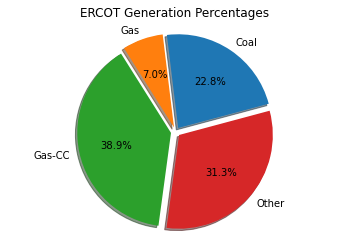

In [12]:
# complete the full percentage, fill with the rest of the sources that are largely non-emissions producing
the_rest = 1.0 - coal_ave - gas_ave - gascc_ave

# pie chart
pie_data = [coal_ave, gas_ave, gascc_ave, the_rest]
pie_labels = ['Coal', 'Gas', 'Gas-CC', 'Other']
explode = [.05, .05, .05, .05] # separates the slices a little bit
plt.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=15, shadow = True, explode=explode)
plt.title('ERCOT Generation Percentages')
plt.axis('equal')
plt.show()

In [13]:
# convert ercot table to percentages:
def add_percentages(column):
    return column / column['Total']

ercot_perc = ercot.apply(add_percentages)
ercot_perc

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
"Energy, GWh",,,,,,,,,,,,,
Biomass,0.001788,0.001660,0.001446,0.001280,0.001958,0.001689,0.001699,0.001487,0.000959,0.001098,0.001181,0.001464,0.001497
Coal,0.283885,0.227743,0.189842,0.237886,0.223165,0.234774,0.236790,0.243272,0.271102,0.281385,0.284228,0.263437,0.247990
Gas,0.045053,0.025519,0.033631,0.036893,0.082426,0.068572,0.106060,0.093838,0.064829,0.069119,0.048921,0.033531,0.062462
Gas-CC,0.341326,0.391244,0.377516,0.341428,0.359958,0.398188,0.442140,0.415287,0.426062,0.357060,0.323446,0.369258,0.382212
Hydro,0.001022,0.001235,0.002016,0.002366,0.001780,0.001314,0.001116,0.001410,0.001175,0.004770,0.004870,0.003939,0.002157
Nuclear,0.121619,0.132538,0.134221,0.107964,0.111108,0.096317,0.093966,0.092838,0.111008,0.099835,0.121638,0.108435,0.109369
Other,0.000096,0.000039,0.000076,0.000078,0.000089,0.000054,0.000101,0.000026,0.000062,0.000103,0.000111,0.000070,0.000077
Solar,0.006067,0.006370,0.009169,0.011522,0.010085,0.009865,0.009305,0.009074,0.007949,0.007173,0.009223,0.007076,0.008617
Wind,0.199144,0.213651,0.252045,0.260581,0.209402,0.189229,0.108849,0.142744,0.116854,0.179388,0.206309,0.212792,0.185618


In [14]:
ercot_perc.index.name = "% of Generation"
ercot_perc

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
% of Generation,,,,,,,,,,,,,
Biomass,0.001788,0.001660,0.001446,0.001280,0.001958,0.001689,0.001699,0.001487,0.000959,0.001098,0.001181,0.001464,0.001497
Coal,0.283885,0.227743,0.189842,0.237886,0.223165,0.234774,0.236790,0.243272,0.271102,0.281385,0.284228,0.263437,0.247990
Gas,0.045053,0.025519,0.033631,0.036893,0.082426,0.068572,0.106060,0.093838,0.064829,0.069119,0.048921,0.033531,0.062462
Gas-CC,0.341326,0.391244,0.377516,0.341428,0.359958,0.398188,0.442140,0.415287,0.426062,0.357060,0.323446,0.369258,0.382212
Hydro,0.001022,0.001235,0.002016,0.002366,0.001780,0.001314,0.001116,0.001410,0.001175,0.004770,0.004870,0.003939,0.002157
Nuclear,0.121619,0.132538,0.134221,0.107964,0.111108,0.096317,0.093966,0.092838,0.111008,0.099835,0.121638,0.108435,0.109369
Other,0.000096,0.000039,0.000076,0.000078,0.000089,0.000054,0.000101,0.000026,0.000062,0.000103,0.000111,0.000070,0.000077
Solar,0.006067,0.006370,0.009169,0.011522,0.010085,0.009865,0.009305,0.009074,0.007949,0.007173,0.009223,0.007076,0.008617
Wind,0.199144,0.213651,0.252045,0.260581,0.209402,0.189229,0.108849,0.142744,0.116854,0.179388,0.206309,0.212792,0.185618


In [15]:
# clean up that percentage table
ercot_perc = ercot_perc.drop(index=['Biomass', 'Hydro', 'Nuclear', 'Other', 'Solar', 'Wind', 'Total'], columns=['Jan', 'Feb', 'Sep', 'Oct', 'Nov', 'Dec', 'Total'])
ercot_perc

,Mar,Apr,May,Jun,Jul,Aug
% of Generation,,,,,,
Coal,0.189842,0.237886,0.223165,0.234774,0.23679,0.243272
Gas,0.033631,0.036893,0.082426,0.068572,0.10606,0.093838
Gas-CC,0.377516,0.341428,0.359958,0.398188,0.44214,0.415287


In [16]:
# index by localminute 
grid_df = grid_df.set_index('localminute')

# bring to central timezone
grid_df = grid_df.tz_localize(tz='US/Central')
grid_df

,dataid,grid
localminute,,
2018-03-01 00:27:00-06:00,9121,0.294
2018-03-01 04:27:00-06:00,8626,0.520
2018-03-01 04:46:00-06:00,8626,0.457
2018-03-01 04:59:00-06:00,8626,0.454
2018-03-01 05:05:00-06:00,8626,0.461
...,...,...
2018-03-01 00:02:00-06:00,2814,0.459
2018-03-01 00:03:00-06:00,2814,0.459
2018-03-01 00:04:00-06:00,2814,0.459


In [17]:
# drop any rows that have blank grid
grid_df = grid_df.dropna(how='any')
grid_df

,dataid,grid
localminute,,
2018-03-01 00:27:00-06:00,9121,0.294
2018-03-01 04:27:00-06:00,8626,0.520
2018-03-01 04:46:00-06:00,8626,0.457
2018-03-01 04:59:00-06:00,8626,0.454
2018-03-01 05:05:00-06:00,8626,0.461
...,...,...
2018-03-01 00:02:00-06:00,2814,0.459
2018-03-01 00:03:00-06:00,2814,0.459
2018-03-01 00:04:00-06:00,2814,0.459


In [18]:
# calculate the average grid usage of the homes over this time period
grouped_grid = grid_df.groupby([pd.Grouper(freq='D')]).mean()
grouped_grid['grid'] = grouped_grid['grid'] * 24 # converts daily average grid use/generation to kWh
grouped_grid

,dataid,grid
localminute,,
2018-03-01 00:00:00-06:00,5374.299935,-5.581169
2018-03-02 00:00:00-06:00,5380.832969,-2.755293
2018-03-03 00:00:00-06:00,5390.512754,9.399256
2018-03-04 00:00:00-06:00,5369.321330,11.987920
2018-03-05 00:00:00-06:00,5377.043049,4.582210
...,...,...
2018-08-27 00:00:00-05:00,5384.253497,31.348641
2018-08-28 00:00:00-05:00,5393.405960,29.150294
2018-08-29 00:00:00-05:00,5393.190556,29.779760


In [19]:
# the above was using the monthly averages from Mar - Aug from ercot all averaged together for each source
# let's use the actual monthy averages for each point instead
grid_more = grouped_grid

In [20]:
# extract and addd the month to the dataframe
grid_more['Month'] = grid_more.index.strftime('%B')
grid_more['Month'] = grid_more['Month'].astype(str)
grid_more

,dataid,grid,Month
localminute,,,
2018-03-01 00:00:00-06:00,5374.299935,-5.581169,March
2018-03-02 00:00:00-06:00,5380.832969,-2.755293,March
2018-03-03 00:00:00-06:00,5390.512754,9.399256,March
2018-03-04 00:00:00-06:00,5369.321330,11.987920,March
2018-03-05 00:00:00-06:00,5377.043049,4.582210,March
...,...,...,...
2018-08-27 00:00:00-05:00,5384.253497,31.348641,August
2018-08-28 00:00:00-05:00,5393.405960,29.150294,August
2018-08-29 00:00:00-05:00,5393.190556,29.779760,August


In [21]:
# convert the month to the same 3 letter abbreviation as in the ERCOT table
def shorten_month(col):
    col['Month'] = col['Month'][0:3]
    return col

grid_more = grid_more.apply(shorten_month, axis=1)
grid_more

,dataid,grid,Month
localminute,,,
2018-03-01 00:00:00-06:00,5374.299935,-5.581169,Mar
2018-03-02 00:00:00-06:00,5380.832969,-2.755293,Mar
2018-03-03 00:00:00-06:00,5390.512754,9.399256,Mar
2018-03-04 00:00:00-06:00,5369.321330,11.987920,Mar
2018-03-05 00:00:00-06:00,5377.043049,4.582210,Mar
...,...,...,...
2018-08-27 00:00:00-05:00,5384.253497,31.348641,Aug
2018-08-28 00:00:00-05:00,5393.405960,29.150294,Aug
2018-08-29 00:00:00-05:00,5393.190556,29.779760,Aug


In [22]:
# Assign based on the monthly percentage breakdown
def assign_lbs(row):
    row['Gas-CC lbs'] = (ercot_perc.loc['Gas-CC', row.Month] * row['grid']) * _gas_cc_lbs
    row['Gas lbs'] = (ercot_perc.loc['Gas', row.Month] * row['grid']) * _gas_lbs
    row['Coal lbs'] = (ercot_perc.loc['Coal', row.Month] * row['grid']) * _coal_lbs
    return row


grid_more = grid_more.apply(assign_lbs, axis=1)
grid_more

,dataid,grid,Month,Gas-CC lbs,Gas lbs,Coal lbs
localminute,,,,,,
2018-03-01 00:00:00-06:00,5374.299935,-5.581169,Mar,-1.580234,-0.187702,-2.341586
2018-03-02 00:00:00-06:00,5380.832969,-2.755293,Mar,-0.780125,-0.092664,-1.155986
2018-03-03 00:00:00-06:00,5390.512754,9.399256,Mar,2.661275,0.316110,3.943468
2018-03-04 00:00:00-06:00,5369.321330,11.987920,Mar,3.394221,0.403170,5.029545
2018-03-05 00:00:00-06:00,5377.043049,4.582210,Mar,1.297392,0.154106,1.922471
...,...,...,...,...,...,...
2018-08-27 00:00:00-05:00,5384.253497,31.348641,Aug,9.764008,2.941697,16.853980
2018-08-28 00:00:00-05:00,5393.405960,29.150294,Aug,9.079300,2.735409,15.672083
2018-08-29 00:00:00-05:00,5393.190556,29.779760,Aug,9.275356,2.794476,16.010503


In [23]:
# don't need these anymore
grid_more = grid_more.drop(columns=['dataid', 'Month'])
grid_more

,grid,Gas-CC lbs,Gas lbs,Coal lbs
localminute,,,,
2018-03-01 00:00:00-06:00,-5.581169,-1.580234,-0.187702,-2.341586
2018-03-02 00:00:00-06:00,-2.755293,-0.780125,-0.092664,-1.155986
2018-03-03 00:00:00-06:00,9.399256,2.661275,0.316110,3.943468
2018-03-04 00:00:00-06:00,11.987920,3.394221,0.403170,5.029545
2018-03-05 00:00:00-06:00,4.582210,1.297392,0.154106,1.922471
...,...,...,...,...
2018-08-27 00:00:00-05:00,31.348641,9.764008,2.941697,16.853980
2018-08-28 00:00:00-05:00,29.150294,9.079300,2.735409,15.672083
2018-08-29 00:00:00-05:00,29.779760,9.275356,2.794476,16.010503


In [24]:
# Add a total CO2 column
grid_more['Total CO2'] = grid_more['Gas-CC lbs'] + grid_more['Gas lbs'] + grid_more['Coal lbs']
grid_more

,grid,Gas-CC lbs,Gas lbs,Coal lbs,Total CO2
localminute,,,,,
2018-03-01 00:00:00-06:00,-5.581169,-1.580234,-0.187702,-2.341586,-4.109522
2018-03-02 00:00:00-06:00,-2.755293,-0.780125,-0.092664,-1.155986,-2.028775
2018-03-03 00:00:00-06:00,9.399256,2.661275,0.316110,3.943468,6.920852
2018-03-04 00:00:00-06:00,11.987920,3.394221,0.403170,5.029545,8.826936
2018-03-05 00:00:00-06:00,4.582210,1.297392,0.154106,1.922471,3.373969
...,...,...,...,...,...
2018-08-27 00:00:00-05:00,31.348641,9.764008,2.941697,16.853980,29.559685
2018-08-28 00:00:00-05:00,29.150294,9.079300,2.735409,15.672083,27.486791
2018-08-29 00:00:00-05:00,29.779760,9.275356,2.794476,16.010503,28.080335


In [26]:
grid_more = grid_more.rename({'grid':'Grid Use (kWh)'} , axis='columns')

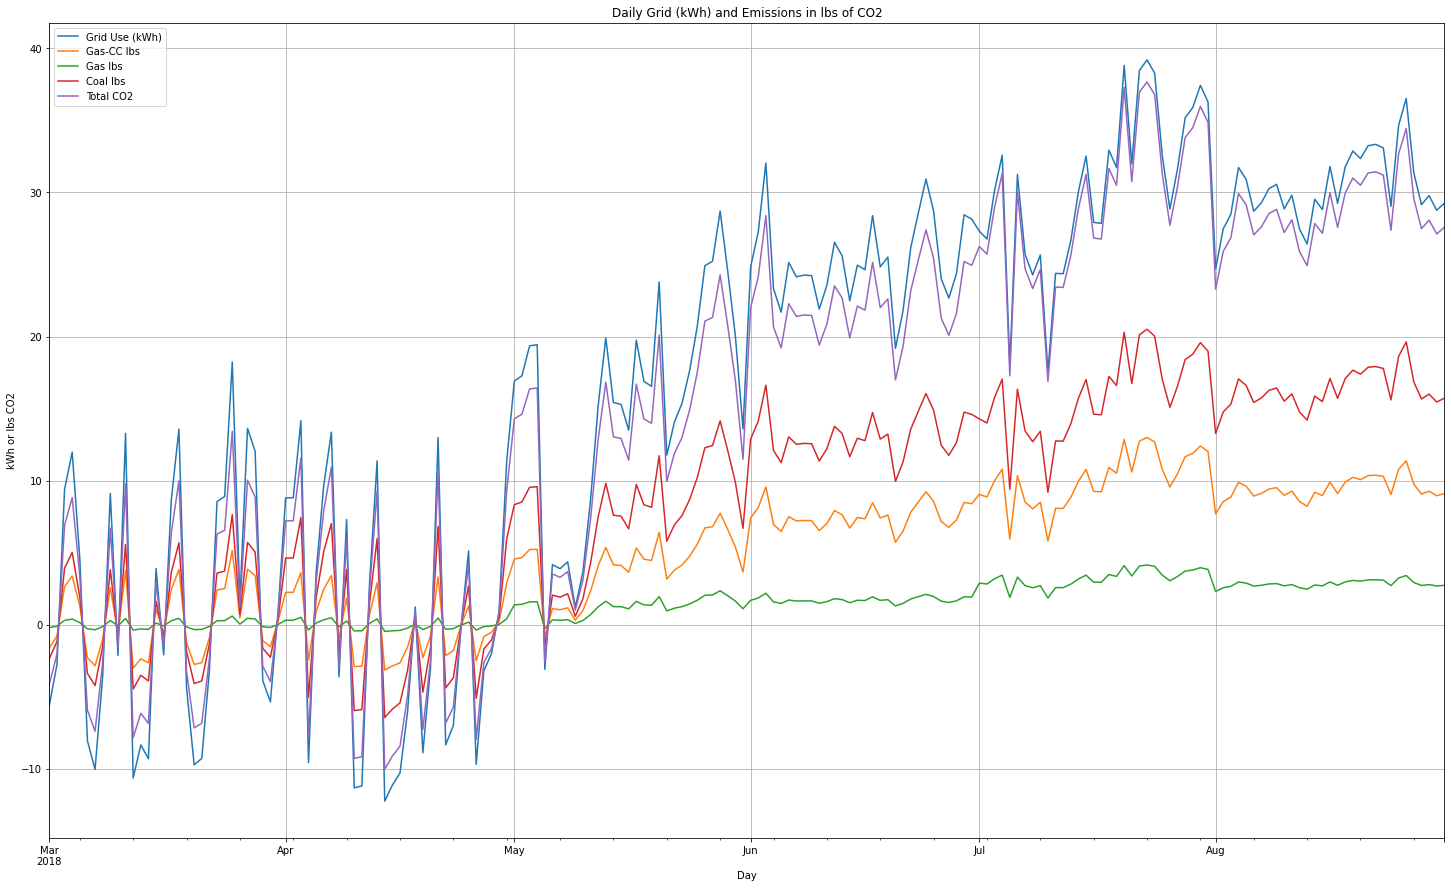

In [28]:
grid_more.plot(figsize=(25,15), title='Daily Grid (kWh) and Emissions in lbs of CO2', grid=True, xlabel='Day', ylabel='kWh or lbs CO2')

# Observations:

- These all solar homes have the capacity to offset some of the neighbors' emissions in the "shoulder months" by putting energy back on the grid
- Total CO2 as measured in lbs/kWh tracks at nearly 1-to-1
